# Notebook 4: Phase 1 - Du bao chuoi thoi gian (Forecasting)

**Muc tieu:**
- Danh gia mo hinh voi Time-Series Split (Train < 2015, Test >= 2015)
- So sanh voi Phase 0.5 (Random Split) de kiem tra Data Leakage
- Mo phong thuc te: Huan luyen tren qua khu, du bao tuong lai

**Ket qua mong doi:**
- Bang so sanh 6 thi nghiem (3 models x 2 approaches)
- So sanh R2 giua Phase 0.5 va Phase 1

## 1. Thiet lap moi truong va tai du lieu

In [1]:
# 1.1 Import thu vien
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor

import sys
import os

# Them src vao path
sys.path.append(os.path.abspath(os.path.join('../src')))
from evaluation import evaluate_model, compare_models
from preprocessing import load_data

# Cau hinh
pd.set_option('display.max_columns', 30)
RANDOM_STATE = 42
TARGET = 'Value_co2_emissions_kt_by_country'
SPLIT_YEAR = 2015  # Train < 2015, Test >= 2015

print('Thu vien da duoc import thanh cong.')

Thu vien da duoc import thanh cong.


In [2]:
# 1.2 Tai du lieu da tien xu ly cho tung model
df_lr = load_data('../data/processed/lr_final_prep.csv')
df_svr = load_data('../data/processed/svr_final_prep.csv')
df_xgb = load_data('../data/processed/xgb_final_prep.csv')

# Kiem tra cot Year trong du lieu
print(f'LR co cot Year: {"Year" in df_lr.columns}')
print(f'SVR co cot Year: {"Year" in df_svr.columns}')
print(f'XGB co cot Year: {"Year" in df_xgb.columns}')

Loaded data from ../data/processed/lr_final_prep.csv: (2190, 193)
Loaded data from ../data/processed/svr_final_prep.csv: (3473, 198)
Loaded data from ../data/processed/xgb_final_prep.csv: (3473, 25)
LR co cot Year: False
SVR co cot Year: True
XGB co cot Year: True


In [3]:
# 1.3 Tai du lieu common de lay thong tin Year (LR va SVR da bi loai Year)
df_common = load_data('../data/processed/common_preprocessed.csv')

# Tao index mapping Year cho LR va SVR
# LR data co it dong hon do loai outliers, can align theo index
print(f'\nPhan bo Year trong du lieu:')
print(f'  Common: {df_common["Year"].min()} - {df_common["Year"].max()}')
print(f'  XGB: {df_xgb["Year"].min()} - {df_xgb["Year"].max()}')
print(f'\nSo luong mau theo nam (XGB):')
print(df_xgb.groupby('Year').size().to_string())

Loaded data from ../data/processed/common_preprocessed.csv: (3473, 25)

Phan bo Year trong du lieu:
  Common: 2001 - 2020
  XGB: 2001 - 2020

So luong mau theo nam (XGB):
Year
2001    172
2002    172
2003    172
2004    172
2005    172
2006    172
2007    172
2008    174
2009    174
2010    174
2011    174
2012    174
2013    174
2014    175
2015    175
2016    175
2017    175
2018    175
2019    175
2020    175


In [4]:
# 1.4 Dinh nghia cac ham tach features (giong Phase 0.5)

def get_pooled_features(df, target, has_entity_onehot=True):
    """
    Pooled Data: Loai bo lag features va Entity encoding.
    """
    df_copy = df.copy()
    lag_cols = [c for c in df_copy.columns if 'lag' in c.lower()]
    
    if has_entity_onehot:
        entity_cols = [c for c in df_copy.columns if c.startswith('Entity_')]
    else:
        entity_cols = ['Entity'] if 'Entity' in df_copy.columns else []
    
    year_cols = ['Year'] if 'Year' in df_copy.columns else []
    drop_cols = lag_cols + entity_cols + year_cols + [target]
    drop_cols = [c for c in drop_cols if c in df_copy.columns]
    
    X = df_copy.drop(columns=drop_cols)
    y = df_copy[target]
    return X, y


def get_panel_features(df, target, has_entity_onehot=True):
    """
    Panel Data: Giu lai lag features va Entity encoding.
    
    LUU Y: Loai bo target_lag (lag cua chinh target CO2) de tranh data leakage.
    Vi CO2(t-1) qua tuong quan voi CO2(t), model chi can hoc CO2(t) ~ CO2(t-1).
    """
    df_copy = df.copy()
    
    # Loai bo target_lag columns (cac cot lag cua chinh bien muc tieu CO2)
    target_lag_cols = [c for c in df_copy.columns if 'co2' in c.lower() and 'lag' in c.lower()]
    
    year_cols = ['Year'] if 'Year' in df_copy.columns else []
    drop_cols = year_cols + [target] + target_lag_cols
    drop_cols = [c for c in drop_cols if c in df_copy.columns]
    
    if target_lag_cols:
        print(f'  [Panel] Loai bo target lag columns de tranh data leakage: {target_lag_cols}')
    
    X = df_copy.drop(columns=drop_cols)
    y = df_copy[target]
    return X, y


print('Cac ham tach features da duoc dinh nghia.')

Cac ham tach features da duoc dinh nghia.


In [5]:
# 1.5 Dinh nghia ham chia du lieu theo thoi gian

def time_series_split(df, df_year_source, split_year, target):
    """
    Chia du lieu theo moc thoi gian.
    Train: Year < split_year
    Test: Year >= split_year
    
    df: DataFrame chinh (co the khong co cot Year)
    df_year_source: DataFrame co cot Year de tham chieu
    """
    # Neu df co cot Year, dung truc tiep
    if 'Year' in df.columns:
        train_mask = df['Year'] < split_year
        test_mask = df['Year'] >= split_year
    else:
        # Neu khong co Year, dung index tu df_year_source
        # Dam bao index khop
        common_idx = df.index.intersection(df_year_source.index)
        year_series = df_year_source.loc[common_idx, 'Year']
        train_mask = year_series < split_year
        test_mask = year_series >= split_year
        # Chi lay cac index co trong ca 2
        df = df.loc[common_idx]
    
    df_train = df[train_mask]
    df_test = df[test_mask]
    
    return df_train, df_test


print(f'Se chia du lieu: Train < {SPLIT_YEAR}, Test >= {SPLIT_YEAR}')

Se chia du lieu: Train < 2015, Test >= 2015


## 2. Pooled Data Approach

**Dac diem:** Coi moi quan sat la doc lap, khong su dung thong tin ve quoc gia va lich su.

In [6]:
# 2.1 Linear Regression - Pooled
print('=== 2.1 LINEAR REGRESSION - POOLED ===')

# Chia theo thoi gian (dung XGB data vi co Year)
df_train_xgb, df_test_xgb = time_series_split(df_xgb, df_xgb, SPLIT_YEAR, TARGET)

# Lay index tuong ung cho LR data
train_idx = df_train_xgb.index.intersection(df_lr.index)
test_idx = df_test_xgb.index.intersection(df_lr.index)

df_lr_train = df_lr.loc[train_idx]
df_lr_test = df_lr.loc[test_idx]

X_train, y_train = get_pooled_features(df_lr_train, TARGET, has_entity_onehot=True)
X_test, y_test = get_pooled_features(df_lr_test, TARGET, has_entity_onehot=True)

print(f'Train size: {X_train.shape[0]} (Year < {SPLIT_YEAR})')
print(f'Test size: {X_test.shape[0]} (Year >= {SPLIT_YEAR})')
print(f'So luong features: {X_train.shape[1]}')

model_lr_pooled = Ridge(alpha=1.0, random_state=RANDOM_STATE)
model_lr_pooled.fit(X_train, y_train)
y_pred = model_lr_pooled.predict(X_test)

result_lr_pooled = evaluate_model(y_test, y_pred, 'Linear Regression - Pooled')

=== 2.1 LINEAR REGRESSION - POOLED ===
Train size: 1533 (Year < 2015)
Test size: 657 (Year >= 2015)
So luong features: 15
--- Linear Regression - Pooled Performance ---
RMSE: 15782.6084
MAE:  7251.7933
R2:   0.8044


In [7]:
# 2.2 SVR - Pooled
print('=== 2.2 SVR - POOLED ===')

# Lay index tuong ung cho SVR data
train_idx = df_train_xgb.index.intersection(df_svr.index)
test_idx = df_test_xgb.index.intersection(df_svr.index)

df_svr_train = df_svr.loc[train_idx]
df_svr_test = df_svr.loc[test_idx]

X_train, y_train = get_pooled_features(df_svr_train, TARGET, has_entity_onehot=True)
X_test, y_test = get_pooled_features(df_svr_test, TARGET, has_entity_onehot=True)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'So luong features: {X_train.shape[1]}')

# SVR voi target scaling (giong Phase 0.5)
model_svr_pooled = TransformedTargetRegressor(
    regressor=SVR(kernel='rbf', C=10, epsilon=0.1),
    transformer=StandardScaler()
)
model_svr_pooled.fit(X_train, y_train)
y_pred = model_svr_pooled.predict(X_test)

result_svr_pooled = evaluate_model(y_test, y_pred, 'SVR - Pooled')

=== 2.2 SVR - POOLED ===
Train size: 2423
Test size: 1050
So luong features: 18
--- SVR - Pooled Performance ---
RMSE: 488419.7011
MAE:  89979.7477
R2:   0.6264


In [8]:
# 2.3 XGBoost - Pooled
print('=== 2.3 XGBOOST - POOLED ===')

X_train, y_train = get_pooled_features(df_train_xgb, TARGET, has_entity_onehot=False)
X_test, y_test = get_pooled_features(df_test_xgb, TARGET, has_entity_onehot=False)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'So luong features: {X_train.shape[1]}')

model_xgb_pooled = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
model_xgb_pooled.fit(X_train, y_train, verbose=False)
y_pred = model_xgb_pooled.predict(X_test)

result_xgb_pooled = evaluate_model(y_test, y_pred, 'XGBoost - Pooled')

=== 2.3 XGBOOST - POOLED ===
Train size: 2423
Test size: 1050
So luong features: 18
--- XGBoost - Pooled Performance ---
RMSE: 410056.8546
MAE:  47445.2244
R2:   0.7367


## 3. Panel Data Approach

**Dac diem:** Su dung Fixed Effects (Entity encoding) va Lag Features de hoc xu huong lich su.

In [9]:
# 3.1 Linear Regression - Panel
print('=== 3.1 LINEAR REGRESSION - PANEL ===')

X_train, y_train = get_panel_features(df_lr_train, TARGET, has_entity_onehot=True)
X_test, y_test = get_panel_features(df_lr_test, TARGET, has_entity_onehot=True)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'So luong features: {X_train.shape[1]} (bao gom Entity One-Hot va Lag)')

model_lr_panel = Ridge(alpha=1.0, random_state=RANDOM_STATE)
model_lr_panel.fit(X_train, y_train)
y_pred = model_lr_panel.predict(X_test)

result_lr_panel = evaluate_model(y_test, y_pred, 'Linear Regression - Panel')

=== 3.1 LINEAR REGRESSION - PANEL ===
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
Train size: 1533
Test size: 657
So luong features: 191 (bao gom Entity One-Hot va Lag)
--- Linear Regression - Panel Performance ---
RMSE: 11432.8747
MAE:  4312.5435
R2:   0.8974


In [10]:
# 3.2 SVR - Panel
print('=== 3.2 SVR - PANEL ===')

X_train, y_train = get_panel_features(df_svr_train, TARGET, has_entity_onehot=True)
X_test, y_test = get_panel_features(df_svr_test, TARGET, has_entity_onehot=True)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'So luong features: {X_train.shape[1]} (bao gom Entity One-Hot va Lag)')

model_svr_panel = TransformedTargetRegressor(
    regressor=SVR(kernel='rbf', C=10, epsilon=0.1),
    transformer=StandardScaler()
)
model_svr_panel.fit(X_train, y_train)
y_pred = model_svr_panel.predict(X_test)

result_svr_panel = evaluate_model(y_test, y_pred, 'SVR - Panel')

=== 3.2 SVR - PANEL ===
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
Train size: 2423
Test size: 1050
So luong features: 195 (bao gom Entity One-Hot va Lag)
--- SVR - Panel Performance ---
RMSE: 491147.7302
MAE:  87827.6361
R2:   0.6222


In [11]:
# 3.3 XGBoost - Panel
print('=== 3.3 XGBOOST - PANEL ===')

X_train, y_train = get_panel_features(df_train_xgb, TARGET, has_entity_onehot=False)
X_test, y_test = get_panel_features(df_test_xgb, TARGET, has_entity_onehot=False)

print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')
print(f'So luong features: {X_train.shape[1]} (bao gom Entity Ordinal va Lag)')

model_xgb_panel = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
model_xgb_panel.fit(X_train, y_train, verbose=False)
y_pred = model_xgb_panel.predict(X_test)

result_xgb_panel = evaluate_model(y_test, y_pred, 'XGBoost - Panel')

=== 3.3 XGBOOST - PANEL ===
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
  [Panel] Loai bo target lag columns de tranh data leakage: ['Value_co2_emissions_kt_by_country_lag1']
Train size: 2423
Test size: 1050
So luong features: 22 (bao gom Entity Ordinal va Lag)
--- XGBoost - Panel Performance ---
RMSE: 406254.3378
MAE:  45936.6143
R2:   0.7415


## 4. Tong hop va so sanh ket qua

In [12]:
# 4.1 Tao bang so sanh tong hop Phase 1
all_results = [
    result_lr_pooled,
    result_svr_pooled,
    result_xgb_pooled,
    result_lr_panel,
    result_svr_panel,
    result_xgb_panel
]

df_results_p1 = compare_models(all_results)
df_results_p1['Approach'] = ['Pooled', 'Pooled', 'Pooled', 'Panel', 'Panel', 'Panel']
df_results_p1['Algorithm'] = ['Linear Regression', 'SVR', 'XGBoost'] * 2
df_results_p1 = df_results_p1[['Algorithm', 'Approach', 'RMSE', 'MAE', 'R2']]

print('\n=== BANG TONG HOP KET QUA PHASE 1 (TIME-SERIES SPLIT) ===')
print(df_results_p1.to_string(index=False))


=== BANG TONG HOP KET QUA PHASE 1 (TIME-SERIES SPLIT) ===
        Algorithm Approach          RMSE          MAE       R2
Linear Regression   Pooled  15782.608388  7251.793282 0.804447
              SVR   Pooled 488419.701130 89979.747710 0.626388
          XGBoost   Pooled 410056.854588 47445.224363 0.736657
Linear Regression    Panel  11432.874708  4312.543540 0.897383
              SVR    Panel 491147.730190 87827.636078 0.622203
          XGBoost    Panel 406254.337842 45936.614313 0.741518


In [13]:
# 4.2 So sanh voi Phase 0.5
print('\n=== SO SANH PHASE 0.5 vs PHASE 1 ===')

# Load ket qua Phase 0.5
df_results_p05 = pd.read_csv('../data/results/phase05_results.csv')

# Tao bang so sanh R2
comparison = pd.DataFrame({
    'Algorithm': ['Linear Regression', 'SVR', 'XGBoost'] * 2,
    'Approach': ['Pooled', 'Pooled', 'Pooled', 'Panel', 'Panel', 'Panel'],
    'R2_Phase05': df_results_p05['R2'].values,
    'R2_Phase1': df_results_p1['R2'].values
})
comparison['R2_Change'] = comparison['R2_Phase1'] - comparison['R2_Phase05']
comparison['Change_%'] = (comparison['R2_Change'] / comparison['R2_Phase05'] * 100).round(2)

print(comparison.to_string(index=False))


=== SO SANH PHASE 0.5 vs PHASE 1 ===
        Algorithm Approach  R2_Phase05  R2_Phase1  R2_Change  Change_%
Linear Regression   Pooled    0.830005   0.804447  -0.025558     -3.08
              SVR   Pooled    0.990318   0.626388  -0.363930    -36.75
          XGBoost   Pooled    0.974667   0.736657  -0.238010    -24.42
Linear Regression    Panel    0.937439   0.897383  -0.040056     -4.27
              SVR    Panel    0.990999   0.622203  -0.368796    -37.21
          XGBoost    Panel    0.975109   0.741518  -0.233590    -23.96


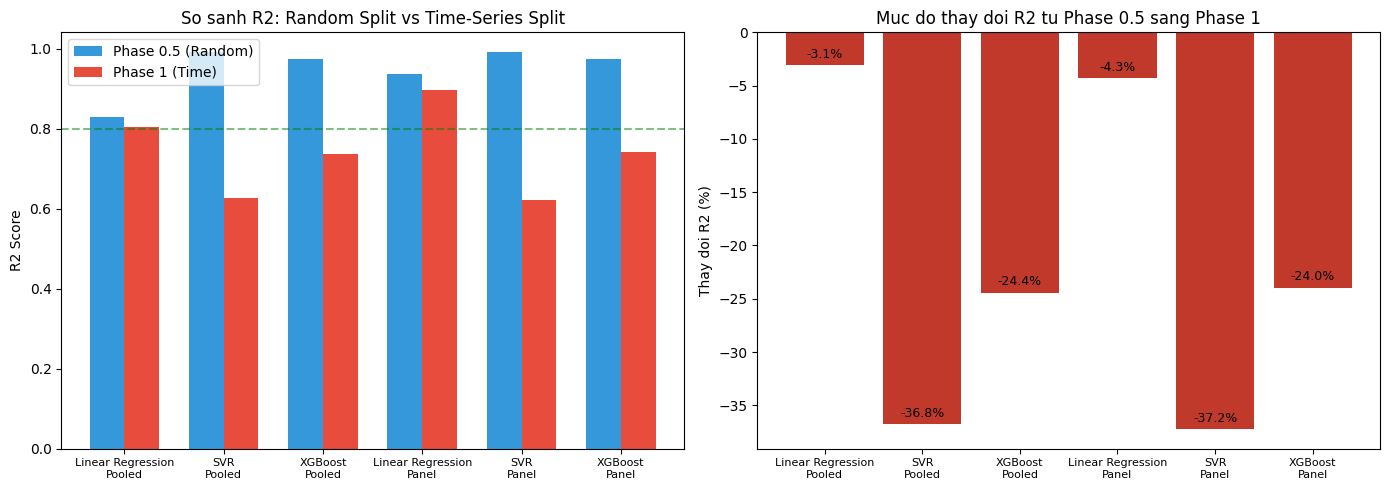

In [14]:
# 4.3 Truc quan hoa so sanh Phase 0.5 vs Phase 1
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: R2 comparison
ax1 = axes[0]
x = np.arange(6)
width = 0.35
labels = [f'{a}\n{b}' for a, b in zip(comparison['Algorithm'], comparison['Approach'])]

bars1 = ax1.bar(x - width/2, comparison['R2_Phase05'], width, label='Phase 0.5 (Random)', color='#3498db')
bars2 = ax1.bar(x + width/2, comparison['R2_Phase1'], width, label='Phase 1 (Time)', color='#e74c3c')

ax1.set_ylabel('R2 Score')
ax1.set_title('So sanh R2: Random Split vs Time-Series Split')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=8)
ax1.legend()
ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Nguong tot (0.8)')

# Chart 2: R2 change percentage
ax2 = axes[1]
colors = ['#27ae60' if x >= 0 else '#c0392b' for x in comparison['Change_%']]
bars = ax2.bar(x, comparison['Change_%'], color=colors)
ax2.set_ylabel('Thay doi R2 (%)')
ax2.set_title('Muc do thay doi R2 tu Phase 0.5 sang Phase 1')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=8)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

for bar, val in zip(bars, comparison['Change_%']):
    ax2.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [15]:
# 4.4 Nhan xet va ket luan
print('\n=== NHAN XET KET QUA PHASE 1 ===')

# Tim model tot nhat
best_idx = df_results_p1['R2'].idxmax()
best_model = df_results_p1.loc[best_idx]

print(f'\n1. Model tot nhat (Phase 1): {best_model["Algorithm"]} - {best_model["Approach"]}')
print(f'   R2 = {best_model["R2"]:.4f}, RMSE = {best_model["RMSE"]:.2f}')

# Phan tich Data Leakage
avg_r2_drop = comparison['R2_Change'].mean()
print(f'\n2. Phan tich Data Leakage:')
print(f'   - Trung binh R2 giam: {avg_r2_drop:.4f} ({avg_r2_drop/comparison["R2_Phase05"].mean()*100:.1f}%)')

if avg_r2_drop < -0.1:
    print('   => Co dau hieu Data Leakage o Phase 0.5 (R2 giam dang ke)')
elif avg_r2_drop < 0:
    print('   => R2 giam nhe, day la binh thuong khi du bao tuong lai')
else:
    print('   => Model on dinh, khong co Data Leakage')

# So sanh Pooled vs Panel
pooled_r2 = df_results_p1[df_results_p1['Approach'] == 'Pooled']['R2'].mean()
panel_r2 = df_results_p1[df_results_p1['Approach'] == 'Panel']['R2'].mean()

print(f'\n3. So sanh Approach (Phase 1):')
print(f'   - Pooled R2 trung binh: {pooled_r2:.4f}')
print(f'   - Panel R2 trung binh: {panel_r2:.4f}')

if panel_r2 > pooled_r2:
    print('   => Panel Data van tot hon Pooled trong du bao thuc te')
else:
    print('   => Pooled Data cho ket qua tuong duong hoac tot hon')

print('\n4. Ket luan:')
print('   - Phase 1 (Time-Series Split) phan anh kha nang du bao thuc te')
print('   - Ket qua nay dang tin cay hon Phase 0.5 (Random Split)')


=== NHAN XET KET QUA PHASE 1 ===

1. Model tot nhat (Phase 1): Linear Regression - Panel
   R2 = 0.8974, RMSE = 11432.87

2. Phan tich Data Leakage:
   - Trung binh R2 giam: -0.2117 (-22.3%)
   => Co dau hieu Data Leakage o Phase 0.5 (R2 giam dang ke)

3. So sanh Approach (Phase 1):
   - Pooled R2 trung binh: 0.7225
   - Panel R2 trung binh: 0.7537
   => Panel Data van tot hon Pooled trong du bao thuc te

4. Ket luan:
   - Phase 1 (Time-Series Split) phan anh kha nang du bao thuc te
   - Ket qua nay dang tin cay hon Phase 0.5 (Random Split)


In [16]:
# 4.5 Luu ket qua
import os
os.makedirs('../data/results', exist_ok=True)

# Luu ket qua Phase 1
df_results_p1.to_csv('../data/results/phase1_results.csv', index=False)
print('Da luu ket qua Phase 1 vao: ../data/results/phase1_results.csv')

# Luu bang so sanh
comparison.to_csv('../data/results/phase05_vs_phase1_comparison.csv', index=False)
print('Da luu bang so sanh vao: ../data/results/phase05_vs_phase1_comparison.csv')

Da luu ket qua Phase 1 vao: ../data/results/phase1_results.csv
Da luu bang so sanh vao: ../data/results/phase05_vs_phase1_comparison.csv
